In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn import linear_model
from sklearn.metrics import r2_score

In [2]:
#fatl_per_Bmiles : Number of drivers involved in fatal collisions per billion miles (2011)
#speeding        : Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding (2009)
#alcohol         : Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired (2011)
#1st             : Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents (2011)

accident_names =['state','fatl_per_Bmiles','speeding','alcohol','1st']
accidents = pd.read_csv('road-accidents.csv',sep='|',skiprows=10,names=accident_names)
accidents_total = pd.DataFrame()
accidents_total = accidents.copy()

miles_names=['state','million_miles']
miles = pd.read_csv('miles-driven.csv',sep='|',skiprows = 1,names=miles_names)

#add miles driven to the dataset and calculate total fatalities------------------------------------
accidents_total['bmiles'] = miles['million_miles']/1000
accidents_total['total_fatalities'] = accidents_total['bmiles']*accidents_total['fatl_per_Bmiles']

In [3]:
#overview of the data
print(accidents.head())

#intuitional conclusion  -------------------------------------------
#from looking at the speeding percentage mean and median(50%) the mean being less than the median could mean that 
# speeding is not a major factor in all states

        state  fatl_per_Bmiles  speeding  alcohol  1st
0     Alabama             18.8        39       30   80
1      Alaska             18.1        41       25   94
2     Arizona             18.6        35       28   96
3    Arkansas             22.4        18       26   95
4  California             12.0        35       28   89


       fatl_per_Bmiles   speeding    alcohol        1st
count        51.000000  51.000000  51.000000   51.00000
mean         15.790196  31.725490  30.686275   88.72549
std           4.122002   9.633438   5.132213    6.96011
min           5.900000  13.000000  16.000000   76.00000
25%          12.750000  23.000000  28.000000   83.50000
50%          15.600000  34.000000  30.000000   88.00000
75%          18.500000  38.000000  33.000000   95.00000
max          23.900000  54.000000  44.000000  100.00000


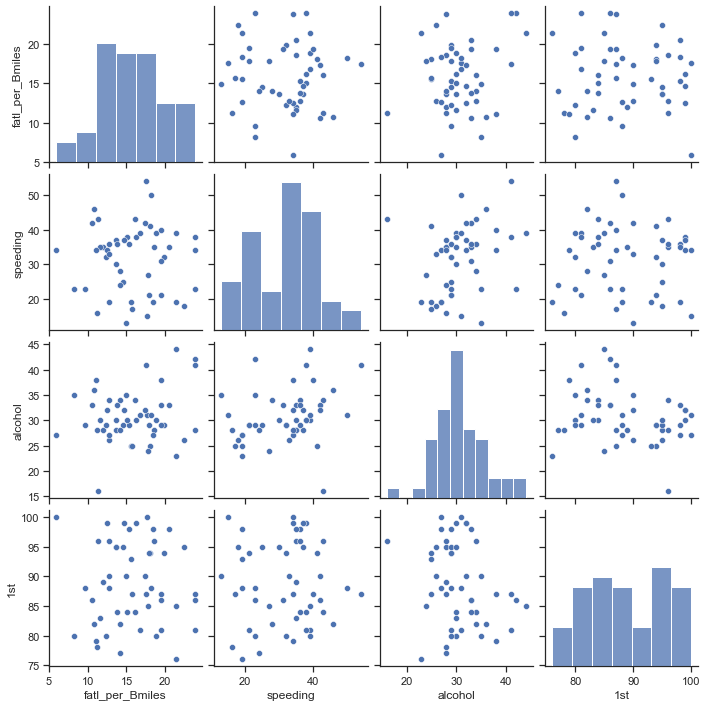

In [4]:
#textual and graphical summary of the data

print(accidents.describe())
sns.set_theme(style="ticks")
sns.pairplot(accidents)

In [5]:
#Quantified association of features and accidents

df_correlation = accidents.corr()
df_correlation

#positive correlation between alcohol and number of fatalities
#also stronger correlation between alcohol and speeding 

,fatl_per_Bmiles,speeding,alcohol,1st
fatl_per_Bmiles,1.000000,-0.029080,0.199426,-0.017942
speeding,-0.029080,1.000000,0.286244,0.014066
alcohol,0.199426,0.286244,1.000000,-0.245455
1st,-0.017942,0.014066,-0.245455,1.000000


In [6]:
#A multivariate linear regression to explore correlations

X = accidents_total[['speeding', 'alcohol', '1st']]
y = accidents_total['fatl_per_Bmiles']
regressor = LinearRegression()
regressor.fit(X, y)
print('Intercept:', regressor.intercept_)
print('Coefficients:', regressor.coef_)

#here we can see that

Intercept: 9.064980483403303
Coefficients: [-0.04180041  0.19086404  0.02473301]


In [7]:
#PCA on standardized data

features = ['fatl_per_Bmiles', 'speeding', 'alcohol', '1st', 'bmiles']
x = accidents_total.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

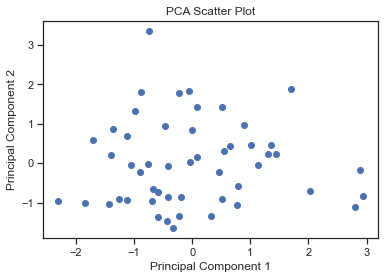

In [8]:
#Visualize the first two principal component

plt.scatter(principal_df['principal component 1'], principal_df['principal component 2'])
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

D:\Apps\Anaconda_New\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


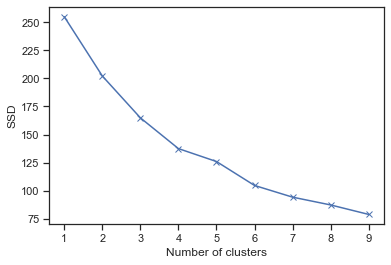

KMeans(n_clusters=3, random_state=42)

In [9]:
# Find clusters of similar states

ssd = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x)

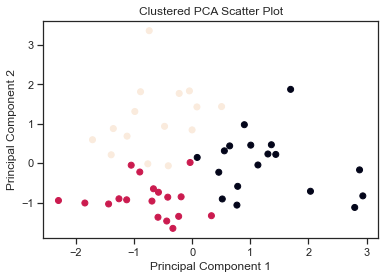

In [10]:
# Visualize clusters in PCA scatter plot

plt.scatter(principal_df['principal component 1'], principal_df['principal component 2'], c=kmeans.labels_)
plt.title('Clustered PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [11]:
# Visualize feature differences between clusters

cluster_df = pd.DataFrame(X, columns=['speeding', 'alcohol', '1st'])
cluster_df['cluster'] = kmeans.labels_

cluster_means = cluster_df.groupby('cluster').mean()
print(cluster_means)
#cluster_df.head()

          speeding    alcohol        1st
cluster                                 
0        39.055556  34.722222  84.444444
1        32.111111  28.444444  96.500000
2        22.466667  28.533333  84.533333


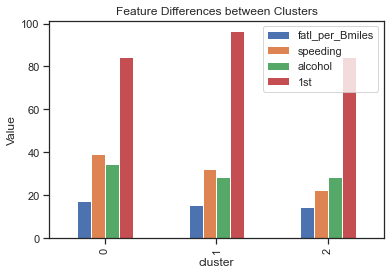

In [12]:
cluster_data = accidents.copy()
cluster_data['cluster'] = kmeans.labels_
means = cluster_data.groupby('cluster').mean()
means.plot(kind='bar')
plt.title('Feature Differences between Clusters')
plt.ylabel('Value')
plt.show()



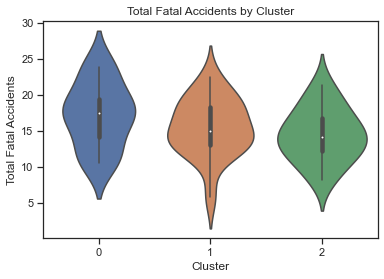

In [13]:
sns.violinplot(x='cluster', y='fatl_per_Bmiles', data = cluster_data)
plt.title('Total Fatal Accidents by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Fatal Accidents')
plt.show()

In [14]:
#Compute the number of accidents within each cluster

#calculating no. accidents based on miles driven and accident rate
cluster_data['total_fatalities']=accidents_total['total_fatalities']
accidents_per_cluster = cluster_data.groupby('cluster')['total_fatalities'].sum() 

#cluster_data.head()
print(accidents_per_cluster)

cluster
0    15277.5763
1    10337.5148
2    20020.1193
Name: total_fatalities, dtype: float64


In [15]:
# Make a decision when there is no clear right choice

print("there is no obvious correct choice regarding which cluster is the most important to focus on.")
print("However, we could argue that Cluster 2 is the most important to focus on because it has the highest number of fatal accidents  and the highest number of miles driven, indicating a higher risk for fatal accidents.")

there is no obvious correct choice regarding which cluster is the most important to focus on.
However, we could argue that Cluster 2 is the most important to focus on because it has the highest number of fatal accidents  and the highest number of miles driven, indicating a higher risk for fatal accidents.
